In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import torch.nn as nn
from torch import tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focalLength = data['focal']

poses[12]
print(images.shape)
print(poses.shape)

width = images.shape[1]
height = images.shape[2]
# plt.imshow(images[10])
for i in range(0, 100):
    plt.imsave(f"im2/image{i}.png", images[i])
# poses[1]

(106, 100, 100, 3)
(106, 4, 4)


In [3]:
numberOfFor = 0
model = nn.Sequential(
	# 3 for the initial x, y,z coordiante
	# then for each fourier feature, one for sin(x), sin(y), sin(z), 
	# and similarily 3 for cos
	nn.Linear(3 + 6*numberOfFor, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	# 3 for r, g, b and last one for radiance
	nn.Linear(300, 4),
	nn.Sigmoid(),
)
model  = model.to(device)

In [4]:
# %matplotlib widget

%matplotlib inline

In [5]:
# returns a two tensors, one with shape [width, height, 3] 
# representing the direction of a ray going through each pixel and another [width, height, 3] 
# representing the starting position of that same ray (all of which are the same) since 
# all rays start out at the origin
def getRays(width, height, focalLength, pose):
	xCoords = tensor([x for x in torch.arange(width)])
	yCoords = tensor([y for y in torch.arange(height)])
	x, y = torch.meshgrid(xCoords, yCoords)
	# print(x[55][49])
	# print(y[55][49])

	xShifted = x - width*0.5 # x coords in a [width, height] tensor
	xShifted = nn.functional.normalize(xShifted)

	yShifted = y - height*0.5 # y coords in a [width, height] tensor
	yShifted = nn.functional.normalize(yShifted)

	z = torch.ones_like(x)  # z coords in a [width, height] tensor

	# match up each element of the 3 tensors (thats why using dim = 2)
	directionVectors = torch.stack((xShifted, yShifted, z), dim=2)
	rotationMatrix = pose[0:3, 0:3]
	rotatedDirections = directionVectors@rotationMatrix
	
	origin =  tensor(pose[:3, 2])

	# all the rays have the same origin
	originTensor =  torch.broadcast_to(origin, rotatedDirections.shape)
	return rotatedDirections, originTensor


	# print(directionVectors.shape)
	# print(xShifted[5][0])
	# print(yShifted[5][99])
	# print(x[4][6])
	# print(y[4][6])
dirs, pos = getRays(width, height, focalLength, poses[10])
print(dirs.shape, pos.shape)
print(dirs[0][0], pos[0][0])


torch.Size([100, 100, 3]) torch.Size([100, 100, 3])
tensor([0.0955, 0.9372, 0.3905]) tensor([-0.8323, -0.5092,  0.2190])


/home/shahanneda/.local/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([100, 100, 50, 3])

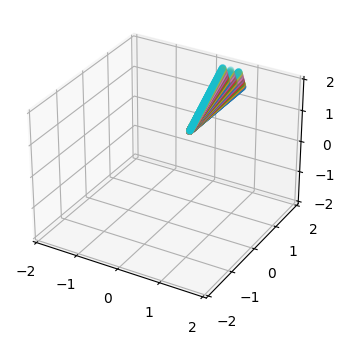

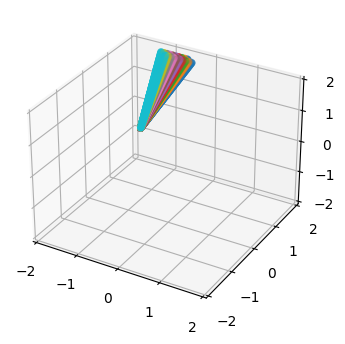

In [6]:
import matplotlib


%matplotlib inline

# matplotlib.use('WebAgg')


numberOfSamples = 50
far = 2
distanceBetweenSamples = 2/50

def get_rays_with_samples(poseNumber):
	dirs, pos = getRays(width, height, focalLength, poses[poseNumber])

	# dirs = (width, height, 3)
	# t = (numberOfSamples)
	# goal = (width, height, numberOfSamples, 3)
	# where goal[x][y][i] = dirs[x][y] * t[i]
	t = torch.linspace(0, far, numberOfSamples).reshape(1, 1, numberOfSamples, 1)

	# dirs has shape (width, height, 3) right now (a direction for every pixel)
	# We want to instead have a list of numberOfSamples for each pixel, so (width, height, numberOfSamples, 3)
	dirs = dirs.reshape(width, height, 1, 3)
	pos = pos.reshape(width, height, 1, 3)
	z = pos + t*dirs
	return z

far = 2
def visulize_3D_rays(poseNumber):
	fig = plt.figure(figsize=(4,4))
	ax = fig.add_subplot(projection='3d')
	rays = get_rays_with_samples(poseNumber)
	for i in range(0, width, 10):
		for j in range(0, height, 10):
			step = 1
			ray = rays[i][j][::step]
			ax.scatter(ray[:, 0], ray[:,1], ray[:, 2])
	ax.set_xlim3d([-far, far])
	ax.set_ylim3d([-far, far])
	ax.set_zlim3d([-far, far])
	ax.set_autoscale_on(False)

	# plt.savefig(f"img/{poseNumber}.png")
# for i in range(0, 100):
	# visulize_3D_rays(i)
visulize_3D_rays(0)
visulize_3D_rays(5)
get_rays_with_samples(10).shape


In [7]:
def get_model_at_each_sample_point(rays):
	rays = rays.to(device)
	return model(rays)
    

# def get_image(model_out):
# 	# model_out = (width, height, numberOfSamples, 4), where r is rgb + d
# 	deltaI = torch.broadcast_to(tensor(distanceBetweenSamples), numberOfSamples)
# 	print(deltaI)

import gc
gc.collect()
torch.cuda.empty_cache()
rays = get_rays_with_samples(0)
out = get_model_at_each_sample_point(rays)
# get_image(out)

In [8]:
def get_image():
	with torch.no_grad():
		# output = torch.zeros((size, size, 3))
		output = model(X)
		output = output.reshape(size, size, 3)
		output = output.to("cpu")
		return output

print(get_image())

NameError: name 'X' is not defined

In [ ]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
for n in pbar:
    preds = model(X)
    loss = loss_fn(preds, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description( f"Loss is {loss}")

    if(n % 10 == 0):
        clear_output()
        image  = get_image()
        plt.imshow(image)
        # if not image_display:
            # image_display = ax.imshow(image)
            # image_display = plt.imshow(image)
            # plt.show()
        # image_display.set_data(image)
        plt.show()
        # fig.canvas.draw()
        # fig.show()
        # image_display.draw()
		

TypeError: range() missing 1 required positional arguments: "end"

In [ ]:
image  = get_image()
plt.imshow(image)

NameError: name 'X' is not defined